In [55]:
import pandas as pd

In [71]:
df = pd.read_csv("../../data/curated/historical_rent_data.csv")

In [72]:
df.historical_dates = pd.to_datetime(df.historical_dates)
df['suburb'] = df.address.str.split(" ").str[-1]
df.replace(to_replace=['none'], value=0, inplace=True)
df = df.drop(columns = "Unnamed: 0")

In [77]:
df = df.rename(columns={"historical_prices":'price'} )

In [78]:
df

,address,latitude,longitude,nbed,nbath,ncar,price,historical_dates,suburb
0,"3803/483 SWANSTON STREET, MELBOURNE",-37.807094,144.962386,3,2,0,"$1,500",2022-09-01,MELBOURNE
1,"3803/483 SWANSTON STREET, MELBOURNE",-37.807094,144.962386,3,2,0,"$1,500",2022-09-01,MELBOURNE
2,"3803/483 SWANSTON STREET, MELBOURNE",-37.807094,144.962386,3,2,0,$800 per week,2022-03-01,MELBOURNE
3,"3803/483 SWANSTON STREET, MELBOURNE",-37.807094,144.962386,3,2,0,$750 Weekly,2022-01-01,MELBOURNE
4,"3803/483 SWANSTON STREET, MELBOURNE",-37.807094,144.962386,3,2,0,$750 Weekly,2020-06-01,MELBOURNE
...,...,...,...,...,...,...,...,...,...
1715,"718/233 COLLINS STREET, MELBOURNE",-37.816010,144.966040,2,1,0,$400 per week,2022-08-01,MELBOURNE
1716,"718/233 COLLINS STREET, MELBOURNE",-37.816010,144.966040,2,1,0,$400 per week,2022-02-01,MELBOURNE
1717,"718/233 COLLINS STREET, MELBOURNE",-37.816010,144.966040,2,1,0,$400,2022-02-01,MELBOURNE
1718,"718/233 COLLINS STREET, MELBOURNE",-37.816010,144.966040,2,1,0,$330 per week,2021-02-01,MELBOURNE


In [79]:
df['price'] = df["price"].str.replace(",","")
df['price'] = df["price"].str.replace(" ","_") # replacing blank space with underline will simplify code in regex

regex_str1 = r'([$]?\d+[.]?\d+\w+[.]*\w*[/]*\w*[wW])' # $650.00 per week
regex_str2 = r'([$]?\d+[.]?\d+$)' # $320
regex_str3 = r'([$]?\d+[.]?\d+\w+[-]?\w+[d]$)' # $490 Fully Furnished
regex_str4 = r'([$]?\d+[.]?\d+\w*[*]+\w*[*]+$)' # $750_**SPACIOUS_APARTMENT**

df['price1']=df['price'].str.extract(regex_str1)
df['price2']=df['price'].str.extract(regex_str2)
df['price3']=df['price'].str.extract(regex_str3)
df['price4']=df['price'].str.extract(regex_str4)

df['weekly_rent'] = df['price1'].where(df['price1'].notnull(), df['price2'])
df['weekly_rent'] = df['weekly_rent'].where(df['weekly_rent'].notnull(), df['price3'])
df['weekly_rent'] = df['weekly_rent'].where(df['weekly_rent'].notnull(), df['price4'])
df = df.drop(['price1','price2','price3', 'price4'],axis=1)
#dff = df[['price', 'weekly_rent']]
#dff.to_csv("re.csv")
#dff1 = dff[dff['weekly_rent'].isna()] #just for checking
#dff1.to_csv('re_null.csv')
df2 = df.dropna(subset = ['weekly_rent'])
df2['weekly_rent'] = df2['weekly_rent'].str.extract('(\d+)').astype(int)

df3 = df2[df2['weekly_rent'] > 10000] # drop the yearly rent ones.
result =  df2[df2['weekly_rent'] < 10000]
result.to_csv("../../data/curated/HIS_3000_re_clean.csv")

print(f'{len(df) - len(df2)} instances were dropped as no weekly rent was demonstrated')
print(f'{len(df3)} instances were dropped as it was annual rent')


46 instances were dropped as no weekly rent was demonstrated
11 instances were dropped as it was annual rent


<ipython-input-79-aaa3c82f04eb>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['weekly_rent'] = df2['weekly_rent'].str.extract('(\d+)').astype(int)


(array([  7.,  45., 373., 526., 418., 114.,  58.,  31.,  23.,  20.,  20.,
          3.,   6.,   6.,   2.,   7.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   2.,   0.,   0.,   0.,   0.,   1.]),
 array([  50. ,  164.2,  278.4,  392.6,  506.8,  621. ,  735.2,  849.4,
         963.6, 1077.8, 1192. , 1306.2, 1420.4, 1534.6, 1648.8, 1763. ,
        1877.2, 1991.4, 2105.6, 2219.8, 2334. , 2448.2, 2562.4, 2676.6,
        2790.8, 2905. , 3019.2, 3133.4, 3247.6, 3361.8, 3476. ]),
 <BarContainer object of 30 artists>)

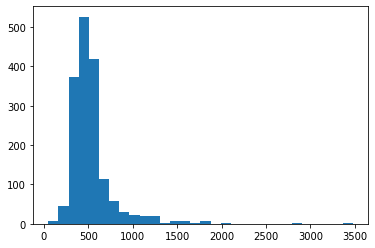

In [80]:
plt.hist(result['weekly_rent'], bins=30)

(array([  3.,  23.,   0.,  18.,   0.,  24.,   0.,  32.,   0.,  37.,   0.,
         72.,   0.,  69.,   0., 107.,  58.,   0.,  59.,   0.,  73.,   0.,
         49.,   0.,  81.,   0., 149.,   0., 144., 665.]),
 array([2006.        , 2006.53333333, 2007.06666667, 2007.6       ,
        2008.13333333, 2008.66666667, 2009.2       , 2009.73333333,
        2010.26666667, 2010.8       , 2011.33333333, 2011.86666667,
        2012.4       , 2012.93333333, 2013.46666667, 2014.        ,
        2014.53333333, 2015.06666667, 2015.6       , 2016.13333333,
        2016.66666667, 2017.2       , 2017.73333333, 2018.26666667,
        2018.8       , 2019.33333333, 2019.86666667, 2020.4       ,
        2020.93333333, 2021.46666667, 2022.        ]),
 <BarContainer object of 30 artists>)

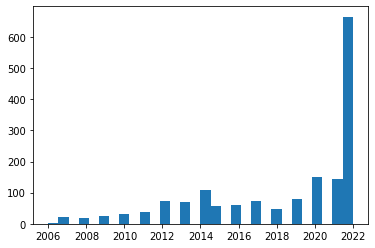

In [83]:
df2 = pd.to_datetime(result['historical_dates'])
years = df2.dt.year
years
plt.hist(years, bins=30)